In [1]:

from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
import torch.nn.functional as F
import functools
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import time

import Augmentor

from torchsummary import summary

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

In [2]:
# Training settings
batch_size = 32

In [19]:
#%%

p = Augmentor.Pipeline()
p.random_erasing(0.5,0.4)




train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop((32, 32), padding=4),   #left, top, right, bottom
    p.torch_transform(),
#     p.sample(10000),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='/home/lee/Research/3.place_lbp_prediction_ISIE2019/Residual_Attention_Network/create_attention_model/data/',
                               train=True,
                               transform=train_transform,
                               download=True)

test_dataset = datasets.CIFAR10(root='/home/lee/Research/3.place_lbp_prediction_ISIE2019/Residual_Attention_Network/create_attention_model/data/',
                              train=False,
                              transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, # 64
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

dataloaders = {
    'train': train_loader,
    'test' : test_loader    
}
image_datasets = {
    'train': train_dataset,
    'test' : test_dataset
}
dataset_sizes = {
    'train': len(image_datasets['train']),
    'test' : len(image_datasets['test'])
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print('train_size: ',dataset_sizes['train'],'\ntest_size : ',dataset_sizes['test'])
print(classes)
print('len class: ', len(classes))



Files already downloaded and verified
train_size:  50000 
test_size :  10000
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
len class:  10


In [20]:
# Get a batch of training data
inputs1, classes = next(iter(dataloaders['train']))

(3, 32, 32)
(32, 32, 3)


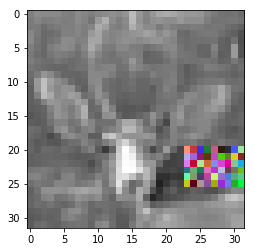

In [21]:
images1 = inputs1[0].numpy()
print(images1.shape)
images1 = np.transpose(images1,[1,2,0])
print(images1.shape)
# plt.subplot(121)
plt.imshow(images1)

In [ ]:
from ResidualUnit_cifar import ResidualBlock
from ASPP_cifar import ASPP_cifar

In [ ]:
class Attention_cifar(nn.Module):
    def __init__(self):
        super(Attention_cifar, self).__init__()
        self.begin_residual_blocks = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
        )#16x16
        self.trunk_first_conv = nn.Sequential(
            nn.Conv2d(64,64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2)
        )#16x16
        self.trunk = nn.Sequential(
            ResidualBlock(64, 256, 1),
            ResidualBlock(256, 256, 1)
        )#56x56
        self.trunk_last_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)            
        )#56x56
        self.trunk_residual = nn.Sequential(
            nn.Conv2d(64,256,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)
#             nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)
        )
#         resnet = ResNet18()
#         self.num_classes = len(class_names)
#         self.resnet = nn.Sequential(*list(resnet.children())[:-2])#8x8

        self.aspp = ASPP_cifar()
        self.mask_first_conv = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=1, stride = 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)
        )#8x8

        self.classconv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 2048, kernel_size=1),
            nn.BatchNorm2d(2048),
            nn.MaxPool2d(2)
        )#8x8
        self.thresholds = nn.Threshold(0.6, 0.05)
        self.mpool = nn.AvgPool2d(kernel_size=8, stride=1)
        # y =  x    if x >= threshold
        #  value    if x <  threshold
        # threshold = 0.1
        # value = 20
        self.fc = nn.Linear(2048,10)
    def forward(self, x):
        h = int(x.size()[2] / 2)
        w = int(x.size()[3] / 2)
        x1 = self.begin_residual_blocks(x)#16x16
#         print(x1.shape)
#         print(x1.shape)
#################trunk_part#################
        out_trunk1 = self.trunk_first_conv(x1)#16x16
        out_trunk2 = self.trunk(out_trunk1)#16x16
        out_trunk3 = self.trunk_last_conv(out_trunk2)#16x16
#         out_trunk = F.upsample(out_trunk, size=(h,w), mode="bilinear")#16x16x256
        out_trunk4 = out_trunk3 + self.trunk_residual(x1)#16x16
        out_trunk4 = F.softmax(out_trunk4)
#################trunk_part#################        

#################mask_part#################
        feature_map = self.mask_first_conv(x1)#16x16x256
        mask1 = self.aspp(feature_map)#8x8x256
#         print(mask.shape)
        mask2 = F.upsample(mask1, size=(h, w), mode="bilinear") #16x16x256
        mask2 = F.softmax(mask2)
        mask2 = self.thresholds(mask2)
#################mask_part#################
        out1 = (1 + mask2) * out_trunk4 #16x16x256
        out1 = F.softmax(out1)
        out2 = self.classconv(out1)#8x8
        out3 = self.mpool(out2)#1x1x512
        out4 = out3.view(out3.size(0),-1)
        out  = self.fc(out4)

        return out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4
        

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
model = Attention_cifar()

In [ ]:
model.apply(weights_init)

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA, model")
    model.cuda() #after second other epoch model
summary(model,(3,32,32))

In [ ]:
writer = SummaryWriter()

In [ ]:
def train_model(model, scheduler, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    avg_loss = 0
    avg_acc = 0
    avg_loss_test = 0
    avg_acc_test = 0
    
    train_batches = len(train_loader)
    test_batches = len(test_loader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_test = 0
        acc_train = 0
        acc_test = 0
        
        model.train(True)
        for i, data in enumerate(train_loader):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
            # Use half training dataset
            if i >= train_batches / 2:
                break
            inputs, labels = data            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs)
            _, preds = torch.max(out, 1)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item() * inputs.size(0)
            acc_train += torch.sum(preds == labels.data)
            del inputs, labels, out, preds
            torch.cuda.empty_cache()
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / len(train_dataset)
        avg_acc = acc_train.double() * 2 / len(train_dataset)
        writer.add_scalar('data/train_loss_places', avg_loss, epoch)
        writer.add_scalar('data/train_acc_places', avg_acc, epoch)
        
        
        model.train(False)
        model.eval()
        for i, data in enumerate(test_loader):
            if i % 100 == 0:
                print()
                print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            with torch.no_grad():
                out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs)
                _, preds = torch.max(out, 1)
                loss = criterion(out, labels)
                loss_test += loss.item() * inputs.size(0)
                acc_test += torch.sum(preds == labels.data)
            
            del inputs, labels, out, preds
            torch.cuda.empty_cache()
        
        avg_loss_test = loss_test / len(test_dataset)
        avg_acc_test = acc_test.double() / len(test_dataset)
        writer.add_scalar('data/val_loss_places', avg_loss_test, epoch)
        writer.add_scalar('data/val_acc_places', avg_acc_test, epoch)
        print()
        print("Epoch {} result: ".format(epoch+1))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (test): {:.4f}".format(avg_loss_test))
        print("Avg acc (test): {:.4f}".format(avg_acc_test))
        print('-' * 10)
        print()
        
        if avg_acc_test > best_acc:
            best_acc = avg_acc_test
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
        # Decaying Learning Rate
        if (epoch+1) / float(total_epoch) == 0.3 or (epoch+1) / float(total_epoch) == 0.6 or (epoch+1) / float(total_epoch) == 0.9:
            lr /= 10
            print('reset learning rate to:', lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                print(param_group['lr'])
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f} at {}".format(best_acc, best_epoch+1))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import copy
lr = 0.001  # 0.1
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
total_epoch = 150
model_train = train_model(model, scheduler, criterion, optimizer, num_epochs=total_epoch)
torch.save(model_train.state_dict(), './Trained/cifar_10_adam_0322.pt')

In [ ]:
############################train more
model_train = Attention_cifar()
 # load the pre-trained weights
model_file = 'model_cifar10_small_2_softmax_attention.pt'
path = '/home/lee/Research/3.place_lbp_prediction_ISIE2019/Residual_Attention_Network/create_attention_model/small_3/Trained/' + model_file
model_train.load_state_dict(torch.load(path))
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA, model_trian")
    model_train.cuda() #after second other epoch model

In [ ]:
import copy
lr = 0.0001  # 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
total_epoch = 400
model_train = train_model(model, criterion, optimizer, lr, num_epochs=total_epoch)
torch.save(model.state_dict(), './Trained/model_cifar10_small_3_trainmore_softmax_attention.pt')